Input Directory: E:\Downloads\BaiduNetdiskDownload\output
Output Directory: E:\Downloads\BaiduNetdiskDownload\hsv
2L7A1994_kmeans.png


KeyboardInterrupt: 

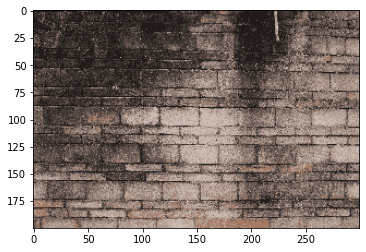

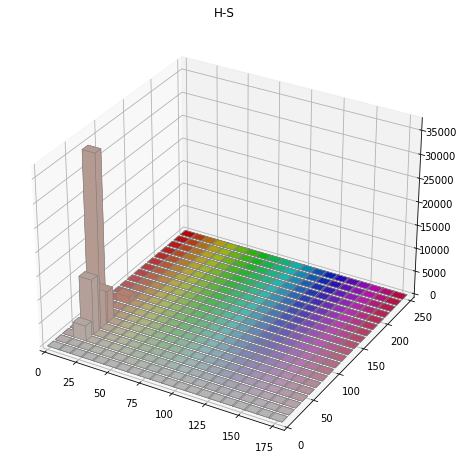

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy.stats import gaussian_kde
import os

def deleteBlack(rgbimg:np.array)->np.array:
    '''
    删除图片中的黑色 rgb = [0,0,0]
    '''
    imgwithoutBlack = []
    for i in range(len(rgbimg)):
        if(rgbimg[i].any()):
            imgwithoutBlack.append(rgbimg[i])
    return np.array(imgwithoutBlack)

def deleteDarkColor(hsvimg:np.array,vVal:int)->np.array:
    '''
    删除图片中的暗色, HSV中的vVal最小值
    '''
    inputlist = []
    for i in range(len(hsvimg)):
        if(hsvimg[i][2]>vVal):
            inputlist.append(hsvimg[i])
    return np.array(inputlist)
    
def Img2HSV(path,resizeK,vVal,outPutFilename):
    '''
    生成HSV分析图
    '''

    #读取图像并resize系数
    
    img = cv2.imread(path)
    img = cv2.resize(img,(int(img.shape[1]*resizeK),int(img.shape[0]*resizeK)))

    #显示输入图片
    plt.imshow(img[:,:,::-1])

    #颜色转换
    rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsvimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsvimg=hsvimg.reshape(-1,3)

    # 删除暗色
    hsvimg = deleteDarkColor(hsvimg,vVal)
    hsvimg=hsvimg.reshape(-1,hsvimg.shape[0],3)
    rgbimg = cv2.cvtColor(hsvimg, cv2.COLOR_HSV2RGB)


    #分别导出HSV
    h, s, v = hsvimg[:,:,0], hsvimg[:,:,1], hsvimg[:,:,2]

    '''
    colorDF = pd.DataFrame({"H":(h.flatten()/10).astype(int)*10,"S":(s.flatten()/10).astype(int)*10,"V":(v.flatten()/10).astype(int)*10})
    colorDF= colorDF.groupby(["H","S"])["V"].count().reset_index(name="Count")
    print(colorDF)
    colorDF["H"]
    '''
    
    #H—S 图设置
    fig1 = plt.figure(figsize=(5, 5))
    ax=plt.subplot(111,projection="polar")
    ax.set_title("Hue - Saturation")
    ax.set_ylim(0,255)
    ax.set_axisbelow('True')  # 使散点覆盖在坐标系之上
    """
    ax.set_thetagrids(np.arange(0.0, 360.0, 15.0))
    ax.set_thetamin(0.0)  # 设置极坐标图开始角度为0°
    ax.set_thetamax(360.0)  # 设置极坐标结束角度为180°
    ax.set_rgrids(np.arange(0, 255.0, 100.0))
    ax.set_rlabel_position(0.0)  # 标签显示在0°
    ax.set_rlim(0.0, 360.0)  # 标签范围为[0, 360)
    
    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)"
    """ 
    h2=np.asarray(h,dtype="float")
    plt.scatter(h2.flatten()*2*math.pi/178.0, s.flatten(), s=10.0,c=rgbimg.reshape(-1,3)/255.0)
    #plt.show()
    plt.savefig(outPutFilename+"_H-S.png")
    plt.close()


    #H-V 图设置
    fig2 = plt.figure(figsize=(5, 5))
    ax=plt.subplot(111,projection="polar")
    ax.set_title("Hue - Value")
    plt.scatter(h2.flatten()*2*math.pi/178.0, v.flatten(), s=10.0,c=rgbimg.reshape(-1,3)/255.0)
    #plt.show()
    plt.savefig(outPutFilename+"_H-V.png")
    plt.close()


    #绘制三维图像
    plot3dhistogram(h.flatten(),s.flatten(),"H-S",outPutFilename)
    plot3dhistogram(h.flatten(),v.flatten(),"H-V",outPutFilename)


def plot3dhistogram(x,y,tag,outPutFilename):
    '''
    绘制三维H-S H-V图
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')

    
    hist, xedges, yedges = np.histogram2d(x, y, bins=20, range=[[0, 179], [0, 255]])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 10* np.ones_like(zpos)
    dz = hist.ravel()
    if(tag=="H-S"):
        colors=np.array(list(zip(xpos, ypos,180*np.ones_like(xpos))),dtype="uint8").reshape(-1,1,3)
    elif(tag=="H-V"):
        colors=np.array(list(zip(xpos,180*np.ones_like(xpos),ypos)),dtype="uint8").reshape(-1,1,3)
    
    colors=cv2.cvtColor(colors, cv2.COLOR_HSV2RGB)
    
    #colors=np.array([(x,y,z) for x in xedges/179 for y in yedges/255])
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort="max",color=colors/255.0,shade=False,edgecolor="gray",linewidth=0.5)
    ax.set_title(tag)
    ax.margins(0)


    #plt.show()
    plt.savefig(outPutFilename+"_"+tag+"_3D.png")
    plt.close()

#输入输出参数设置
InputDir = r"E:\Downloads\BaiduNetdiskDownload\output" # 输入文件夹路径
OutputDir = r"E:\Downloads\BaiduNetdiskDownload\hsv"  # 输出文件夹路径
resizeK = 1  # 0~1，图像尺寸缩减系数, 适用于对整个文件夹合并后的图片进行分析，建议时间允许情况下不要resize，resize容易出现色差。
vVal=30 # 0~255，用于去除图片中的深色，HSV颜色模式下，忽略V值小于vVal的颜色

os.chdir(InputDir)
print("Input Directory: " + InputDir)
print("Output Directory: " + OutputDir)
filenames = os.listdir()
for filename in filenames:
    print(filename)
    filenamewithoutextension=filename.split(".")[0] #删去扩展名
    outPutFilename = OutputDir+"/"+filenamewithoutextension
    Img2HSV(filename,resizeK,vVal,outPutFilename)